# Bucur Robert - Adrian
# Bogdan Gheorghe - Nicolae
## Grupa 10LF381

# Laborator 11
## Modele de clasificare text

# Setul de date Sentiment Labelled Sentences

In [1]:
import numpy as np
import pandas as pd
import string
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import ngrams

import matplotlib.pyplot as plt

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, f1_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertadrianbucur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Incarcarea setului de date

In [2]:
sentiment = pd.read_csv('../data/sentiment/imdb_labelled.txt', sep="\t", header=None)

sentiment.head()

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


# Statistica

## Eliminarea stopwords si afisarea numarului de aparitii a ficarui cuvant

In [3]:
countVectorizer = CountVectorizer(stop_words=stopwords.words('english'))
countVectorizer.fit(sentiment.loc[:,0])
words_frequency = dict(countVectorizer.vocabulary_.items())

pd.DataFrame(np.matrix(list(countVectorizer.vocabulary_.items())), columns=['word', 'frequency'])

,word,frequency
0,slow,2316
1,moving,1683
2,aimless,87
3,movie,1681
4,distressed,720
...,...,...
2911,jessice,1384
2912,clothes,461
2913,virtue,2775
2914,regrettable,2058


## Afisam numarul de review-uri pozitive/negative,
## lungimile cuvintelor: minim, maxim, mediu
## si cel mai frecvent cuvant

Total pozitive reviews: 362
Total negative reviews: 386
Min word length: 1
Max word length: 1390
Mean word length: 19
The most frequent word: [('zombiez', 2915)]


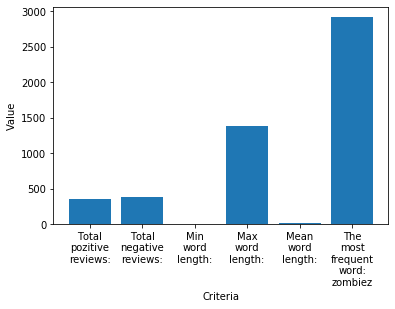

In [4]:
total_pozitive_reviews = len(sentiment[sentiment[1]==0])
print('Total pozitive reviews:', total_pozitive_reviews)
total_negative_reviews = len(sentiment[sentiment[1]==1])
print('Total negative reviews:', total_negative_reviews)

word_length_sentiment = sentiment.loc[:,0].apply(lambda x: len(x.split()))
print('Min word length:', word_length_sentiment.min())
print('Max word length:', word_length_sentiment.max())
print('Mean word length:', int((word_length_sentiment.mean())))

most_frequent_word = [(key, value)  for (key, value) in words_frequency.items() if value == max(words_frequency.values())]
print('The most frequent word:', most_frequent_word)

x = np.array(['Total\npozitive\nreviews:', 'Total\nnegative\nreviews:', 'Min\nword\nlength:', 'Max\nword\nlength:', 'Mean\nword\nlength:', 'The\nmost\nfrequent\nword:\n' + most_frequent_word[0][0]])
y = np.array([total_pozitive_reviews, total_negative_reviews, word_length_sentiment.min(), word_length_sentiment.max(), int((word_length_sentiment.mean())), most_frequent_word[0][1]])
plt.bar(x, y)
plt.xlabel('Criteria')
plt.ylabel('Value')
plt.show()

## Afisarea fiecarui review cu numarul de cuvinte

In [5]:
words_number = sentiment.loc[:, 0].apply(lambda x:len(str(x).split(' ')))

pd.DataFrame(np.matrix(list(zip(sentiment[0], words_number))), columns=['text', 'no_words'])

,text,no_words
0,"A very, very, very slow-moving, aimless movie ...",15
1,Not sure who was more lost - the flat characte...,21
2,Attempting artiness with black & white and cle...,33
3,Very little music or anything to speak of.,10
4,The best scene in the movie was when Gerardo i...,23
...,...,...
743,I just got bored watching Jessice Lange take h...,13
744,"Unfortunately, any virtue in this film's produ...",16
745,"In a word, it is embarrassing.",8
746,Exceptionally bad!,4


# Preprocesare

## Am convertit la litere mici

In [6]:
sentiment[0] = sentiment[0].apply(lambda x: x.lower())
sentiment[0]

0      a very, very, very slow-moving, aimless movie ...
1      not sure who was more lost - the flat characte...
2      attempting artiness with black & white and cle...
3           very little music or anything to speak of.  
4      the best scene in the movie was when gerardo i...
                             ...                        
743    i just got bored watching jessice lange take h...
744    unfortunately, any virtue in this film's produ...
745                     in a word, it is embarrassing.  
746                                 exceptionally bad!  
747    all in all its an insult to one's intelligence...
Name: 0, Length: 748, dtype: object

## Am eliminat cifrele/numerele

In [7]:
sentiment[0] = sentiment[0].apply(lambda x: re.sub(r'\d+', ' ', x))
sentiment[0]

0      a very, very, very slow-moving, aimless movie ...
1      not sure who was more lost - the flat characte...
2      attempting artiness with black & white and cle...
3           very little music or anything to speak of.  
4      the best scene in the movie was when gerardo i...
                             ...                        
743    i just got bored watching jessice lange take h...
744    unfortunately, any virtue in this film's produ...
745                     in a word, it is embarrassing.  
746                                 exceptionally bad!  
747    all in all its an insult to one's intelligence...
Name: 0, Length: 748, dtype: object

## Am eliminat semnele de punctuatie

In [8]:
sentiment[0] = sentiment[0].apply(lambda x: re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\]ˆ_`{|}~]', '', x))
sentiment[0]

0      a very very very slowmoving aimless movie abou...
1      not sure who was more lost  the flat character...
2      attempting artiness with black  white and clev...
3            very little music or anything to speak of  
4      the best scene in the movie was when gerardo i...
                             ...                        
743    i just got bored watching jessice lange take h...
744    unfortunately any virtue in this films product...
745                       in a word it is embarrassing  
746                                  exceptionally bad  
747    all in all its an insult to ones intelligence ...
Name: 0, Length: 748, dtype: object

## Am eliminat spatiile albe (mai exact tab-urile \t)

In [9]:
sentiment[0] = sentiment[0].apply(lambda x: x.strip())
sentiment[0]

0      a very very very slowmoving aimless movie abou...
1      not sure who was more lost  the flat character...
2      attempting artiness with black  white and clev...
3              very little music or anything to speak of
4      the best scene in the movie was when gerardo i...
                             ...                        
743    i just got bored watching jessice lange take h...
744    unfortunately any virtue in this films product...
745                         in a word it is embarrassing
746                                    exceptionally bad
747    all in all its an insult to ones intelligence ...
Name: 0, Length: 748, dtype: object

## Am eliminat spatiile duble

In [10]:
sentiment[0] = sentiment[0].apply(lambda x: re.sub(r'\s{2,}', ' ', x))
sentiment[0]

0      a very very very slowmoving aimless movie abou...
1      not sure who was more lost the flat characters...
2      attempting artiness with black white and cleve...
3              very little music or anything to speak of
4      the best scene in the movie was when gerardo i...
                             ...                        
743    i just got bored watching jessice lange take h...
744    unfortunately any virtue in this films product...
745                         in a word it is embarrassing
746                                    exceptionally bad
747    all in all its an insult to ones intelligence ...
Name: 0, Length: 748, dtype: object

## Am transformat cuvintele derivate in cuvinte radacina

In [11]:
stemmer= PorterStemmer()
sentiment[0] = sentiment[0].apply(lambda x: stemmer.stem(x))
sentiment[0]

0      a very very very slowmoving aimless movie abou...
1      not sure who was more lost the flat characters...
2      attempting artiness with black white and cleve...
3              very little music or anything to speak of
4      the best scene in the movie was when gerardo i...
                             ...                        
743    i just got bored watching jessice lange take h...
744    unfortunately any virtue in this films product...
745                            in a word it is embarrass
746                                    exceptionally bad
747    all in all its an insult to ones intelligence ...
Name: 0, Length: 748, dtype: object

# Codificare BoW

In [12]:
bow = CountVectorizer(analyzer="word")
X = bow.fit_transform(sentiment.iloc[:, 0])
y = sentiment.iloc[:, 1]

# Clasificare

In [13]:
sentiment_df = pd.DataFrame()

In [14]:
parameters_dtc = {'splitter': ['best', 'random'], 'max_depth': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
parameters_knn = {'n_neighbors': list(range(1, 10)), 'p': [1, 2, 3, 4.7]}
parameters_svc = {'gamma': ['auto', 'scale'], 'C': list(range(1, 10))}
parameters_rfc = {'max_depth': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

## Primul model de clasificare: DecisionTreeClassifier

In [15]:
grid_search_dtc = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters_dtc, scoring='f1', cv=3)
grid_scores_dtc = cross_validate(estimator=grid_search_dtc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_grid_sentiment = pd.DataFrame(grid_scores_dtc)
df_grid_sentiment = df_grid_sentiment.mean()
df_grid_sentiment['Model_name'] = 'DecisionTreeClassifier'
df_grid_sentiment['Search_strategy'] = 'GridSearch'

df_grid_sentiment = pd.Series(df_grid_sentiment)
sentiment_df = sentiment_df.append(df_grid_sentiment, ignore_index=True)

In [16]:
randomized_search_dtc = RandomizedSearchCV(estimator=DecisionTreeClassifier(), param_distributions=parameters_dtc, random_state=0, scoring='f1', cv=3, n_iter=5)
randomized_scores_dtc = cross_validate(estimator=randomized_search_dtc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_randomized_sentiment = pd.DataFrame(randomized_scores_dtc)
df_randomized_sentiment = df_randomized_sentiment.mean()
df_randomized_sentiment['Model_name'] = 'DecisionTreeClassifier'
df_randomized_sentiment['Search_strategy'] = 'RandomizedSearch'

df_randomized_sentiment = pd.Series(df_randomized_sentiment)
sentiment_df = sentiment_df.append(df_randomized_sentiment, ignore_index=True)

## Al doilea model de clasificare: KNeighborsClassifier

In [17]:
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters_knn, scoring='f1', cv=3)
grid_scores_knn = cross_validate(estimator=grid_search_knn, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_grid_sentiment = pd.DataFrame(grid_scores_knn)
df_grid_sentiment = df_grid_sentiment.mean()
df_grid_sentiment['Model_name'] = 'KNeighborsClassifier'
df_grid_sentiment['Search_strategy'] = 'GridSearch'

df_grid_sentiment = pd.Series(df_grid_sentiment)
sentiment_df = sentiment_df.append(df_grid_sentiment, ignore_index=True)

In [18]:
randomized_search_knn = RandomizedSearchCV(estimator=KNeighborsClassifier(), param_distributions=parameters_knn, random_state=0, scoring='f1', cv=3, n_iter=5)
randomized_scores_knn = cross_validate(estimator=randomized_search_knn, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_randomized_sentiment = pd.DataFrame(randomized_scores_knn)
df_randomized_sentiment = df_randomized_sentiment.mean()
df_randomized_sentiment['Model_name'] = 'KNeighborsClassifier'
df_randomized_sentiment['Search_strategy'] = 'RandomizedSearch'

df_randomized_sentiment = pd.Series(df_randomized_sentiment)
sentiment_df = sentiment_df.append(df_randomized_sentiment, ignore_index=True)

## Al treilea model de clasificare: SVM.SVC

In [19]:
grid_search_svc = GridSearchCV(estimator=SVC(), param_grid=parameters_svc, scoring='f1', cv=3)
grid_scores_svc = cross_validate(estimator=grid_search_svc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_grid_sentiment = pd.DataFrame(grid_scores_svc)
df_grid_sentiment = df_grid_sentiment.mean()
df_grid_sentiment['Model_name'] = 'SVC'
df_grid_sentiment['Search_strategy'] = 'GridSearch'

df_grid_sentiment = pd.Series(df_grid_sentiment)
sentiment_df = sentiment_df.append(df_grid_sentiment, ignore_index=True)

In [20]:
randomized_search_svc = RandomizedSearchCV(estimator=SVC(), param_distributions=parameters_svc, random_state=0, scoring='f1', cv=3, n_iter=5)
randomized_scores_svc = cross_validate(estimator=randomized_search_svc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_randomized_sentiment = pd.DataFrame(randomized_scores_svc)
df_randomized_sentiment = df_randomized_sentiment.mean()
df_randomized_sentiment['Model_name'] = 'SVC'
df_randomized_sentiment['Search_strategy'] = 'RandomizedSearch'

df_randomized_sentiment = pd.Series(df_randomized_sentiment)
sentiment_df = sentiment_df.append(df_randomized_sentiment, ignore_index=True)

## Al patrulea model de clasificare: RandomForestClassifier

In [21]:
grid_search_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters_rfc, scoring='f1', cv=3)
grid_scores_rfc = cross_validate(estimator=grid_search_rfc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_grid_sentiment = pd.DataFrame(grid_scores_rfc)
df_grid_sentiment = df_grid_sentiment.mean()
df_grid_sentiment['Model_name'] = 'RandomForestClassifier'
df_grid_sentiment['Search_strategy'] = 'GridSearch'

df_grid_sentiment = pd.Series(df_grid_sentiment)
sentiment_df = sentiment_df.append(df_grid_sentiment, ignore_index=True)

In [22]:
randomized_search_rfc = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=parameters_rfc, random_state=0, scoring='f1', cv=3, n_iter=5)
randomized_scores_rfc = cross_validate(estimator=randomized_search_rfc, scoring=('accuracy', 'f1'), X=X, y=y, cv=5, return_train_score=True)

df_randomized_sentiment = pd.DataFrame(randomized_scores_rfc)
df_randomized_sentiment = df_randomized_sentiment.mean()
df_randomized_sentiment['Model_name'] = 'RandomForestClassifier'
df_randomized_sentiment['Search_strategy'] = 'RandomizedSearch'

df_randomized_sentiment = pd.Series(df_randomized_sentiment)
sentiment_df = sentiment_df.append(df_randomized_sentiment, ignore_index=True)

# Raportul final

In [23]:
sentiment_df

,Model_name,Search_strategy,fit_time,score_time,test_accuracy,test_f1,train_accuracy,train_f1
0,DecisionTreeClassifier,GridSearch,0.498384,0.005550,0.538828,0.689071,0.551456,0.695842
1,DecisionTreeClassifier,RandomizedSearch,0.132549,0.003492,0.538828,0.689071,0.551456,0.695842
2,KNeighborsClassifier,GridSearch,2.103713,0.027777,0.565494,0.651313,0.881700,0.899931
3,KNeighborsClassifier,RandomizedSearch,0.362900,0.040366,0.566792,0.634839,0.733288,0.773725
4,SVC,GridSearch,3.374050,0.019023,0.705817,0.720371,0.978291,0.978952
5,SVC,RandomizedSearch,0.942537,0.023163,0.569745,0.676538,0.654622,0.752698
6,RandomForestClassifier,GridSearch,13.164714,0.022785,0.518711,0.678583,0.546125,0.693795
7,RandomForestClassifier,RandomizedSearch,4.829067,0.025209,0.525405,0.684451,0.530410,0.686898


In [24]:
sentiment_df.style.highlight_max(color='red').highlight_min(color='green')

,Model_name,Search_strategy,fit_time,score_time,test_accuracy,test_f1,train_accuracy,train_f1
0,DecisionTreeClassifier,GridSearch,0.498384,0.005550,0.538828,0.689071,0.551456,0.695842
1,DecisionTreeClassifier,RandomizedSearch,0.132549,0.003492,0.538828,0.689071,0.551456,0.695842
2,KNeighborsClassifier,GridSearch,2.103713,0.027777,0.565494,0.651313,0.881700,0.899931
3,KNeighborsClassifier,RandomizedSearch,0.362900,0.040366,0.566792,0.634839,0.733288,0.773725
4,SVC,GridSearch,3.374050,0.019023,0.705817,0.720371,0.978291,0.978952
5,SVC,RandomizedSearch,0.942537,0.023163,0.569745,0.676538,0.654622,0.752698
6,RandomForestClassifier,GridSearch,13.164714,0.022785,0.518711,0.678583,0.546125,0.693795
7,RandomForestClassifier,RandomizedSearch,4.829067,0.025209,0.525405,0.684451,0.530410,0.686898


## Randarea fisierului html

In [29]:
sentiment_html = sentiment_df.style.highlight_max(color='red').highlight_min(color='green').render()

text_file = open('../html_files/sentiment.html', 'w')
text_file.write('<br>')
text_file.write('<h1><center> Dataset: Sentiment Labelled Sentences <center></h1>')
text_file.write('<br><br><br><br><br><br><br><center>')
text_file.write(sentiment_html)
text_file.write('</center>')
text_file.close()